# Importign required modules

In [22]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [23]:
# Train transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Test transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [24]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [25]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

SEED = 1
# To reproduce the same results across the sessions
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)
  dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
else:
  dataloader_args = dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model

In [26]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24


        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12


        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [27]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

In [28]:
from tqdm import tqdm

# Aggregate loss and accuracy
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get batch data
    data, target = data.to(device), target.to(device)

    # Reset all gradients to zero
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Do calculate the grads in dackpropagation
    loss.backward()

    # Update the model weights
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Aggregate batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Update total test data loss
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Training & Testing

In [29]:
from torch.optim.lr_scheduler import StepLR

# Creat the mode and move it to CUDA
model = Net().to(device)

# Using stochastic gradient descent method for optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.13942350447177887 Batch_id=468 Accuracy=86.77: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]



Test set: Average loss: 0.0668, Accuracy: 9806/10000 (98.06%)

EPOCH: 1


Loss=0.06125277653336525 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]



Test set: Average loss: 0.0422, Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Loss=0.04288545623421669 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]



Test set: Average loss: 0.0341, Accuracy: 9903/10000 (99.03%)

EPOCH: 3


Loss=0.0902373418211937 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]



Test set: Average loss: 0.0308, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.04078933969140053 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]



Test set: Average loss: 0.0286, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.055290285497903824 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]



Test set: Average loss: 0.0242, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.07012765854597092 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]



Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 7


Loss=0.01632884331047535 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]



Test set: Average loss: 0.0204, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.02330571599304676 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]



Test set: Average loss: 0.0194, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.07335495948791504 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]



Test set: Average loss: 0.0199, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.03694691136479378 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:25<00:00, 18.16it/s]



Test set: Average loss: 0.0193, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.0272172000259161 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]



Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.006882220506668091 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:25<00:00, 18.45it/s]



Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.01554546132683754 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]



Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.017442187294363976 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]



Test set: Average loss: 0.0191, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


Loss=0.04917290806770325 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:25<00:00, 18.18it/s]



Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.02063160389661789 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]



Test set: Average loss: 0.0186, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.020877107977867126 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]



Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.04043532535433769 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]



Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.014403432607650757 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]



Test set: Average loss: 0.0189, Accuracy: 9936/10000 (99.36%)



Text(0.5, 1.0, 'Test Accuracy')

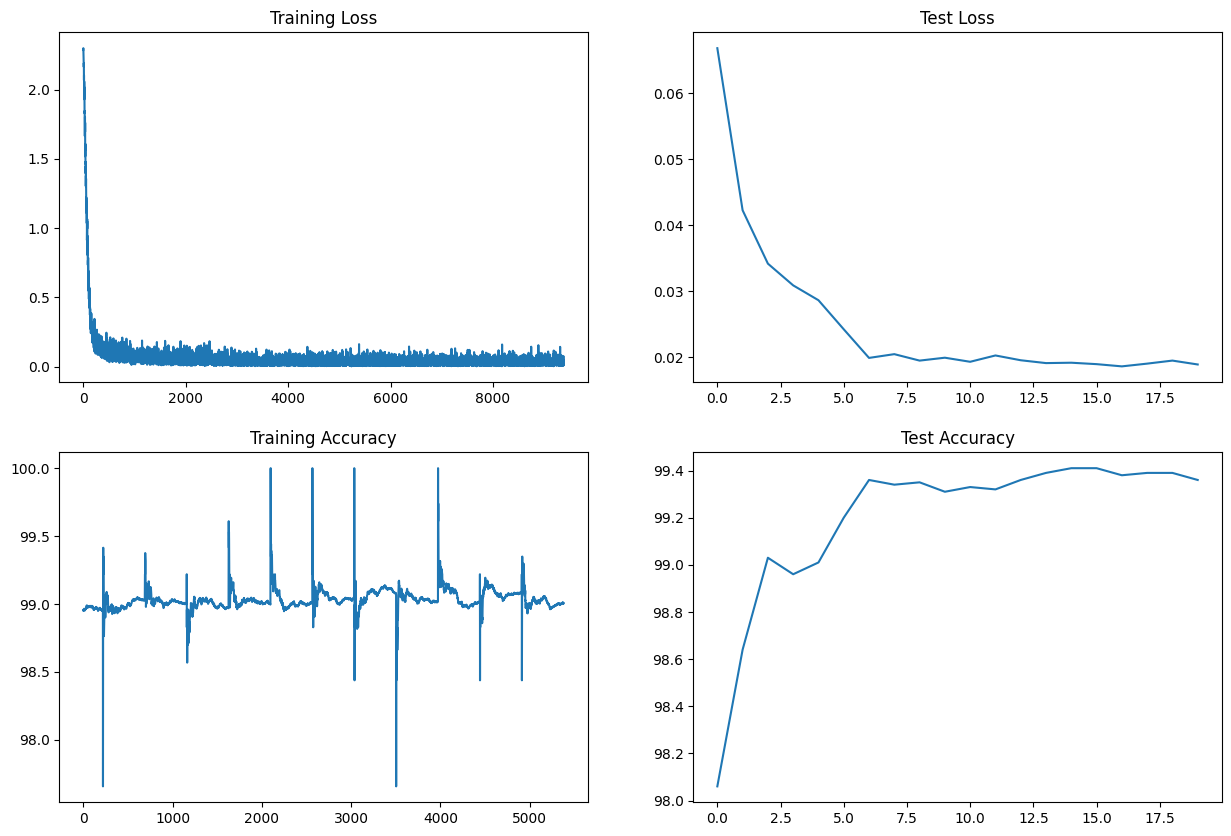

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Iteration 10
---
##Target:
*   Applying LR scheduler with a step size as 6 and gamma as 0.1

##Results:
*   Total params: 13,808
*   Best Training Accuracy: 99.08%
*   Best Test Accuracy: 99.41%

##Analysis:
*   There is underfitting due to harder training data.
*   Test accuracy touched the target value only couple of times.
